<a href="https://colab.research.google.com/github/AnusuiyaBhorkar/Effects-of-data-amount-and-variation-in-deep-learning-based-TB-diagnosis-in-chest-X-ray-scans/blob/main/Fully_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
#Function goal: To get all of the tensorflow data using input variables
def get_tf_data(data_path, batch_size, image_size, seed, split_ratio):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        color_mode="grayscale",
        label_mode="binary",
        batch_size=batch_size,
        image_size=(image_size[0], image_size[1]),
        shuffle=True,
        seed=seed,
        validation_split=split_ratio,
        subset="training"
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        color_mode="grayscale",
        label_mode="binary",
        batch_size=batch_size,
        image_size=(image_size[0], image_size[1]),
        shuffle=True,
        seed=seed,
        validation_split=split_ratio,
        subset="validation"
    )
    return train_ds, val_ds
    #given these input variables, outputting the datasets for training and validation. doesn't mean the content is in that variable, ONLY the settings and how it will be uploaded.

In [ ]:
data_path = '/content/drive/MyDrive/Veritas AI/Veritas AI - Anusuiya/data/combined_MZT_all'

batch_size = 8
image_size = (224, 224)
#1 is the number of channels, everything is grayscale and everything is only one channel
seed = 42
split_ratio = 0.20
epochs = 50

In [ ]:
train_ds, val_ds = get_tf_data(data_path, batch_size, image_size, seed, split_ratio)
class_names = train_ds.class_names
print(class_names)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
['normal', 'tuberculosis']


In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(image_size[0], image_size[1], 3), input_tensor=None, include_top=False, weights='imagenet', pooling=None)
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
inputlayer = tf.keras.Input(shape=(image_size[0], image_size[1], 1))  # Grayscale input
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='relu')(inputlayer)  # Convert grayscale to 3 channels
x = base_model(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2())(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2())(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model(inputlayer, output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,934,431 (68.41 MB)

 Trainable params: 17,934,431 (68.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'binary_focal_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 3)         │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,934,431 (68.41 MB)

 Trainable params: 17,934,431 (68.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
VGG16_history = model.fit(train_ds, validation_data=val_ds, batch_size = batch_size, epochs=epochs)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.7799 - loss: 1.9273 - val_accuracy: 0.9360 - val_loss: 0.7785
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.8922 - loss: 0.7006 - val_accuracy: 0.9360 - val_loss: 0.4515
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9342 - loss: 0.4029 - val_accuracy: 0.9500 - val_loss: 0.2858
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.9416 - loss: 0.2547 - val_accuracy: 0.9290 - val_loss: 0.2194
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.9472 - loss: 0.1689 - val_accuracy: 0.9550 - val_loss: 0.1312
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.9545 - loss: 0.1159 - val_accuracy: 0.9550 - val_loss: 0.0939
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.9653 - loss: 0.0840 - val_accuracy: 0.9560 - val_loss: 0.0873
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.9610 - loss: 0.0666 -

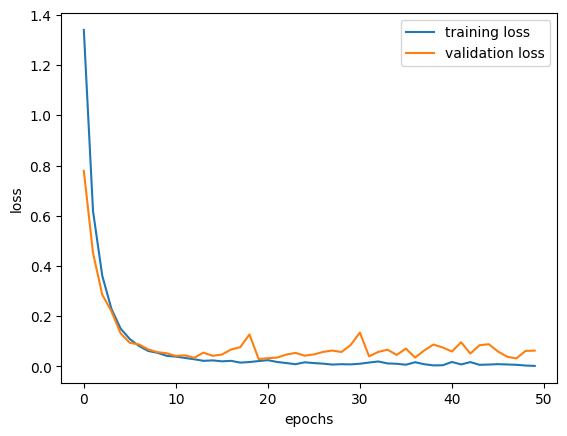

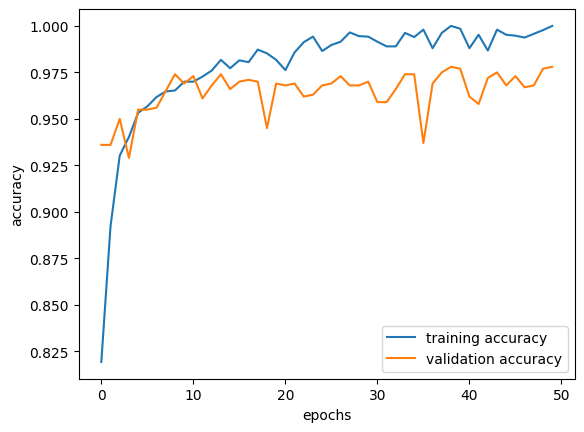

In [ ]:
plt.figure()
plt.plot(VGG16_history.history['loss'], label='training loss')
plt.plot(VGG16_history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(VGG16_history.history['accuracy'], label='training accuracy')
plt.plot(VGG16_history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Veritas AI/Veritas AI - Anusuiya/code/models/MST_.h5')